
# **Seizure time-series data classification**





**Objectuve:** Classify time-series from EEG recordings to binary classes of *Seizure* (class 1) and *Normal* (class 0).

**Classification algorithms:** Popular algorithms that can be used for binary classification include:


*   K-Nearest Neighbors
*   Logistic Regression
*   Naive Bayes
*   Decision Trees
*   Support Vector Machine

# **Load the data**

In [1]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount google drive to use with google colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/TimeSeriesAnalysis/
%ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/TimeSeriesAnalysis
demo1_ARmodel.ipynb  demo2_seizureClassification.ipynb  epilepsy.csv


In [3]:
# Import data using pandas
import pandas as pd
df = pd.read_csv('./epilepsy.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,-14,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,312,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,-15,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,-69,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,1,...,38,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,5


**Data organization:**

The original data comes from the reference below:

*   Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE (2001) Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state, *Phys. Rev. E*, 64, 061907

The original dataset from the reference consists of 23.5 seconds of EEG recordings (time-series with 4097 data points) from 500 individuals. We will be using a modified version of the dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition) (also available [here](https://github.com/Mr-Jree/Epileptic-Seizure-Binary-Classification)). 

In the modified version, each time-series is divided into 23 time-series of 1 second (178 data points) EEG recording. Thus, the original 500 time-series of 23 seconds are transformed to 11500 time-series of 1 second. The new 11500 time-series are the *samples* (rows) and the 178 data points (1 second EEG recording) are the *features* (columns) in our classification analysis. The last column includes the *labels* (dependant variable) and is a categorial variable (1, 2, 3, 4, 5). The categories correspond to: (1) seizure activity; (2, 3) patient has a tumor; (4, 5) eyes open/closed during recording.

Since we are only interested in seizure classification against the rest, we will modify the labels to: (1) seizure and (0) no-seizure classes.

In [4]:
# Modify labels to binary classes (1 indicates seizure)
df['binaryLabel'] = df.y == 1 
df['binaryLabel'] = df['binaryLabel'].astype(int)
df.pop('y')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,binaryLabel
0,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,-14,...,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,312,...,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,-15,...,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,-69,...,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,1,...,38,26,10,-4,-13,-8,0,10,19,29,57,63,45,7,-13,-23,-9,9,11,3,-1,-2,4,18,27,27,14,15,11,10,4,2,-12,-32,-41,-65,-83,-89,-73,0


**Data exploration:**

Let's get the features and labels in separate matrices:

In [5]:
X_eeg = df.iloc[:, :-1]
y_label = df['binaryLabel']

What is the prevalence of the positive classes to begin with?

In [6]:
print('prevalence of the positive class: %.3f' 
      % (sum(y_label)/len(y_label)))

prevalence of the positive class: 0.200


 Visualizing the data:

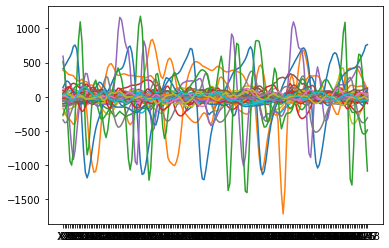

In [7]:
import matplotlib.pyplot as plt

# let's look at a a few sample time-series
for i in range(50):
  plt.plot(X_eeg.iloc[i, :])

In [8]:
# non-zero mean
X_eeg.mean(axis=1)

0       -16.910112
1        28.112360
2       -44.044944
3       -68.910112
4        -6.651685
           ...    
11495     5.157303
11496     5.674157
11497     6.752809
11498   -38.842697
11499    -2.112360
Length: 11500, dtype: float64

Demeaning each time-series (each row):

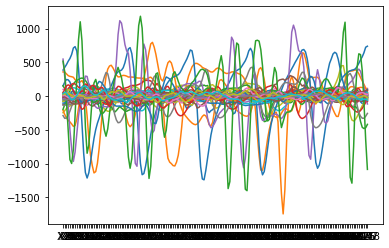

In [9]:
X_eeg_demean = X_eeg.sub(X_eeg.mean(axis=1), axis=0)
for i in range(50):
  plt.plot(X_eeg_demean.iloc[i, :])

In [10]:
# let's calculate the mean again. Yes, it's close to zero!
X_eeg_demean.mean(axis=1)

0        5.109521e-15
1        3.129581e-14
2       -2.554760e-15
3        5.109521e-15
4        2.506859e-14
             ...     
11495   -1.540840e-14
11496    1.325282e-14
11497    4.383011e-14
11498    7.664281e-15
11499   -5.388948e-15
Length: 11500, dtype: float64

# **Classification analysis**

## **Data split**

Split the demeaned data into training, validation, and test sets

In [11]:
from sklearn.model_selection import train_test_split

# split the data into subsets with the retios below
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X_eeg_demean, y_label, 
                                                    test_size=1 - train_ratio,
                                                    shuffle=True,
                                                    random_state=111)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, 
                                                    test_size=test_ratio/(test_ratio + validation_ratio),
                                                    shuffle=True,
                                                    random_state=111) 

print('Training set shape: %s \nValidation set shape: %s \nTest set shape: %s' 
      % (X_train.shape, X_valid.shape, X_test.shape))

Training set shape: (8625, 178) 
Validation set shape: (1725, 178) 
Test set shape: (1150, 178)


In [12]:
# Let's check the prevalence of positive cases in the new sets
print('prevalence of the positive class in training set: %.3f' 
      % (sum(y_train)/len(y_train)))

print('prevalence of the positive class in validation set: %.3f' 
      % (sum(y_valid)/len(y_valid)))

print('prevalence of the positive class in test set: %.3f' 
      % (sum(y_test)/len(y_test)))

prevalence of the positive class in training set: 0.203
prevalence of the positive class in validation set: 0.194
prevalence of the positive class in test set: 0.183


## **Generate a classification report**

Let's load some of the main classification metrics:


In [13]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score

def print_report(y_actual, y_pred):
    # balanced accuracy takes the data imbalance into account
    accuracy = balanced_accuracy_score(y_actual, y_pred)
    # recall is the ability of the classifier to find all the positive samples 
    # (true pos / true pos+false neg)
    recall = recall_score(y_actual, y_pred)
    # precision is the ability of the classifier not to label as positive a sample that is negative
    # (true pos / true pos+false pos)
    precision = precision_score(y_actual, y_pred)
    # F1 score can be interpreted as a weighted average of the precision and recall
    f1score = f1_score(y_actual, y_pred, 'weighted') # "weighted" option takes into account data imbalance

    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('F1-score:%.3f'%f1score)
    print(' ')
    return accuracy, recall, precision, f1score

## **Model Selection**

## K nearest neighbors (KNN)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
# Train KNN Classifier
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train, y_train)

# Predict y using trained classifier
y_train_preds = knn.predict(X_train)
y_valid_preds = knn.predict(X_valid)

# Model performance
print('KNN')
print('Training:')
knn_train_accuracy, knn_train_recall, knn_train_precision, knn_train_f1 = \
  print_report(y_train,y_train_preds)
print('Validation:')
knn_valid_accuracy, knn_valid_recall, knn_valid_precision, knn_valid_f1 = \
  print_report(y_valid,y_valid_preds)

KNN
Training:
accuracy:0.577
recall:0.155
precision:1.000
F1-score:0.268
 
Validation:
accuracy:0.582
recall:0.165
precision:1.000
F1-score:0.283
 


Not so good! Maybe we can play with the number of neighbors (k), but let's try another classifier for now.

## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
# Train LogisticRegression Classifier
lr = LogisticRegression(random_state=111)
lr.fit(X_train, y_train)

# Predict y using trained classifier
y_train_preds = lr.predict(X_train)
y_valid_preds = lr.predict(X_valid)

# Model performance
print('Logistic Regression')
print('Training:')
lr_train_accuracy, lr_train_recall, lr_train_precision, lr_train_f1 = \
  print_report(y_train,y_train_preds)
print('Validation:')
lr_valid_accuracy, lr_valid_recall, lr_valid_precision, lr_valid_f1 = \
  print_report(y_valid,y_valid_preds)

Logistic Regression
Training:
accuracy:0.621
recall:0.524
precision:0.322
F1-score:0.399
 
Validation:
accuracy:0.561
recall:0.446
precision:0.249
F1-score:0.319
 


Maybe a bit better (better F1-score), also much faster than KNN. But not so much. Again we can play with the model parameters, but let's move on for now.

## Gaussian Naive Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB
# Train Gaussian NB Classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predict y using trained classifier
y_train_preds = nb.predict(X_train)
y_valid_preds = nb.predict(X_valid)

# Model performance
print('Naive Bayes')
print('Training:')
nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_f1 = \
  print_report(y_train,y_train_preds)
print('Validation:')
nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_f1 = \
  print_report(y_valid,y_valid_preds)

Naive Bayes
Training:
accuracy:0.943
recall:0.916
precision:0.889
F1-score:0.902
 
Validation:
accuracy:0.946
recall:0.916
precision:0.903
F1-score:0.909
 


Woohoo!! Now this is already much better! We get a high performance in validation set (which is unseen to the model). Let's try another one!



## Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
# Train DecisionTree Classifier
tree = DecisionTreeClassifier(max_depth=10, random_state=111)
tree.fit(X_train, y_train)

# Predict y using trained classifier
y_train_preds = tree.predict(X_train)
y_valid_preds = tree.predict(X_valid)

# Model performance
print('Decision Tree')
print('Training:')
tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_f1 = \
  print_report(y_train,y_train_preds)
print('Validation:')
tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_f1 = \
  print_report(y_valid,y_valid_preds)

Decision Tree
Training:
accuracy:0.958
recall:0.918
precision:0.988
F1-score:0.952
 
Validation:
accuracy:0.888
recall:0.802
precision:0.882
F1-score:0.840
 


Not too bad! Let's try something different here and see whether we can improve the model performance by tweaking some of the parameters.

## Hyperparameter tuning for Decision Tree Classifier

Perform a GridSearch to tune hyperparameters in Decision Trees. 

In [19]:

# For the GridSearch, we will use the predefined validation set to measure 
# the performance of classifier (using PredefinedSplit function). PredefinedSplit 
# assignes index -1 to training set and index 0 to validation set. Therefore, 
# the performance is measured only on validation set for each comibination of hyperparameters.

import time
import numpy as np
# let's see how long this takes
start = time.time()

# prepare the data for GridSeacrhCV by combining training and validation sets
X_train_cv = np.concatenate((X_train, X_valid), axis = 0)
y_train_cv = np.concatenate((y_train, y_valid))

# make indices for training and validation such that training index is -1 and validation index is zero.
# this step is to make sure the performance is measured on the validation set and not the training set.
index_train = np.zeros((len(X_train)))
index_train[:] = -1
index_valid = np.zeros((len(X_valid)))

# make cv index for PredefinedSplit that is going to be fed to GridSearchCV to measure perfromance on validation set
index_cv = np.concatenate((index_train, index_valid))

# now let's start the GridSearch
from sklearn.model_selection import PredefinedSplit
# now the PredefinedSplit function will know which samples are from the validation set (based on the indices we defined)
ps =  PredefinedSplit(test_fold=index_cv)

# Perform exhaustive GridSearch for parameters of DecisionTree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer # we'll use F1-Score here only to make our lives easier

grid_scorer = make_scorer(f1_score, average='weighted')

# define parameter space
parameters = {'max_depth': [None, 30, 100],
              'min_samples_split': [2, 100],
              'min_samples_leaf': [1, 100],
              'max_leaf_nodes': [None, 100]}

tree = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=111)
clf = GridSearchCV(tree, parameters, cv=ps, scoring=grid_scorer)

clf.fit(X_train_cv, y_train_cv)

end = time.time()

print('Finished running in %.3f seconds' % (end-start))

Finished running in 107.683 seconds


In [20]:
# identify the parameters of the best model performance
best_hyperparam = clf.best_params_

best_max_depth = best_hyperparam.get('max_depth')
best_max_leaf_nodes = best_hyperparam.get('max_leaf_nodes')
best_min_samples_leaf = best_hyperparam.get('min_samples_leaf')
best_min_samples_split = best_hyperparam.get('min_samples_split')
best_score = clf.best_score_

print('\nBest hyperparameters found by GridSearch:',
      '\nBest max_depth = %s' % best_max_depth ,
      '\nBest max_leaf_nodes = %s' % best_max_leaf_nodes,
      '\nBest min_samples_leaf = %s' % best_min_samples_leaf,
      '\nBest min_samples_split = %s' % best_min_samples_split,
      '\n\nBest score obtained by GridSearch, measured on validation set:',
      '\nF1-measure(weighted) = %.3f' % best_score)


Best hyperparameters found by GridSearch: 
Best max_depth = None 
Best max_leaf_nodes = 100 
Best min_samples_leaf = 1 
Best min_samples_split = 2 

Best score obtained by GridSearch, measured on validation set: 
F1-measure(weighted) = 0.950


In [21]:
# use best hyperparameters to train the classifier again. Then predict y for train, valid and test sets
bestTree = DecisionTreeClassifier(criterion='gini', splitter='best',
                                  random_state=111,
                                  max_depth=best_max_depth,
                                  min_samples_split=best_min_samples_split,
                                  min_samples_leaf=best_min_samples_leaf,
                                  max_leaf_nodes=best_max_leaf_nodes)
bestTree.fit(X_train, y_train)

# Predict Y using trained classifier
y_train_pred = bestTree.predict(X_train)
y_valid_pred = bestTree.predict(X_valid)
y_test_pred = bestTree.predict(X_test)

# Measure F1
F1_train_best = f1_score(y_train, y_train_pred, average='weighted')
F1_valid_best = f1_score(y_valid, y_valid_pred, average='weighted')
F1_test_best = f1_score(y_test, y_test_pred, average='weighted')

print('\nPerformance of Decision Tree Classifier:',
      '\n\nTraining set:',
      '\nF1-measure(weighted) = %.3f' % F1_train_best, 
      '\n\nValidation set:',
      '\nF1-measure(weighted) = %.3f' % F1_valid_best,
      '\n\nTest set:',
      '\nF1-measure(weighted) = %.3f' % F1_test_best)


Performance of Decision Tree Classifier: 

Training set: 
F1-measure(weighted) = 0.988 

Validation set: 
F1-measure(weighted) = 0.950 

Test set: 
F1-measure(weighted) = 0.946


Awesome! Model performance on the completely unseen test set looks pretty good! 

This is fun! Let's try something else!

## Support Vectore Machine (SVM)

In [22]:
from sklearn.svm import SVC
# Train SVC Classifier
svc = SVC(random_state=111)
svc.fit(X_train, y_train)

# Predict y using using trained classifier
y_train_preds = svc.predict(X_train)
y_valid_preds = svc.predict(X_valid)

# Model performance
print('SVC')
print('Training:')
svc_train_accuracy, svc_train_recall, svc_train_precision, svc_train_f1 = \
  print_report(y_train,y_train_preds)
print('Validation:')
svc_valid_accuracy, svc_valid_recall, svc_valid_precision, svc_valid_f1 = \
  print_report(y_valid,y_valid_preds)

SVC
Training:
accuracy:0.963
recall:0.932
precision:0.977
F1-score:0.954
 
Validation:
accuracy:0.951
recall:0.910
precision:0.962
F1-score:0.935
 


The model is doing great without any hyperparameter tuning! But let's see if we can improve it even more.

## Hyperparameter tuning for Support Vector Machine

In [29]:
start = time.time()

# search for hyperparameter C
# Default C is 1, it must be a positive value. We'll scan over C=[0.001, 100]
cval = np.logspace(-3,2,10)
F1_train = []
F1_valid = []
for c in range(len(cval)):
    # Train SVC Classifier
    svc = SVC(C=cval[c], random_state=111)
    svc.fit(X_train, y_train)

    # Predict Y using trained classifier
    y_train_pred = svc.predict(X_train)
    y_valid_pred = svc.predict(X_valid)

    # Measure F1
    F1_train.append(f1_score(y_train, y_train_pred, average='weighted'))
    F1_valid.append(f1_score(y_valid, y_valid_pred, average='weighted'))
    
F1_train = np.array(F1_train)
F1_valid = np.array(F1_valid)

end = time.time()

print('Finished running in %.3f seconds' % (end-start))

Finished running in 82.194 seconds


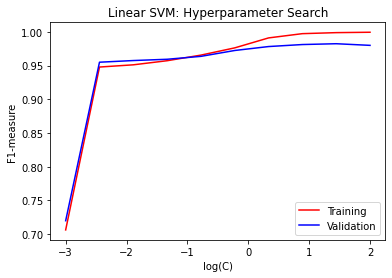

In [30]:
# Plot F1-score for validation and traning sets. We're looking for the C value that 
# corresponds to highest F1-score in validation set.
plt.plot(np.log10(cval), F1_train, 'r', label = 'Training')
plt.plot(np.log10(cval), F1_valid, 'b', label = 'Validation')

plt.xlabel('log(C)')
plt.ylabel('F1-measure')
plt.title('Linear SVM: Hyperparameter Search')

plt.legend()

In [31]:
#pick the best C
best_C = cval[np.argmax(F1_valid)]

print('Best C = %.3f' % best_C)
print('Log(best C) = %.3f' % np.log10(best_C))
print('F1-Measure for best C (validation set) = %.3f' % F1_valid[np.argmax(F1_valid)])

Best C = 27.826
Log(best C) = 1.444
F1-Measure for best C (validation set) = 0.983


In [32]:
# use best C to train the classifier again. Then predict Y for train, valid and test sets
bestSVC = SVC(C=best_C, random_state=111)
bestSVC.fit(X_train, y_train)

# Predict Y using trained classifier
y_train_pred = bestSVC.predict(X_train)
y_valid_pred = bestSVC.predict(X_valid)
y_test_pred = bestSVC.predict(X_test)

# Measure F1
F1_train_best = f1_score(y_train, y_train_pred, average='weighted')
F1_valid_best = f1_score(y_valid, y_valid_pred, average='weighted')
F1_test_best = f1_score(y_test, y_test_pred, average='weighted')

print('\nPerformance of Linear SVM Classifier:',
      '\n\nTraining set:',
      '\nF1-measure(weighted) = %.3f' % F1_train_best, 
      '\n\nValidation set:',
      '\nF1-measure(weighted) = %.3f' % F1_valid_best,
      '\n\nTest set:',
      '\nF1-measure(weighted) = %.3f' % F1_test_best)


Performance of Linear SVM Classifier: 

Training set: 
F1-measure(weighted) = 0.999 

Validation set: 
F1-measure(weighted) = 0.983 

Test set: 
F1-measure(weighted) = 0.971


Perfect! Model performance on unseen test set is great!

## Conclusion

It seems like Support Vector Machine is a pretty good classifier in successfully detecting seizure time-series in unseen test data (F1-score = 0.97)! However we didn't perform hyperparameter tuning for all the classifiers. We might be able to get high performance with the other ones too.
